## Import libraries

In [1]:
from langgraph.graph import StateGraph
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, END
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv
import os
from langchain_tavily import TavilySearch
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from colorama import Fore, Back
load_dotenv()

True

## Message State for graph

In [2]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Create Graph and Agents
#### I have created a sequential graph like this:
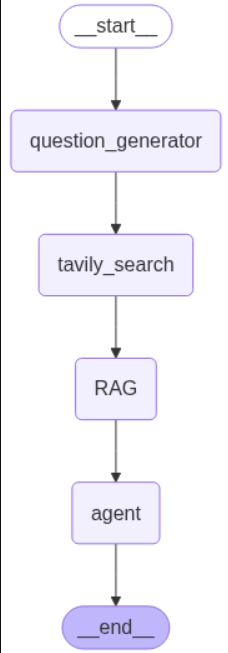

It has 3 agents: 
1. Question_generator: It generates multiple questions as search queries for tavily search. This gives a more in depth details about the compitition.
2. Agent: It takes all the context generated from RAG and generate the final report.
3. RAG: It stores all the results generated by Tavily and saves it in a RAG.

It has 1 tool:
1. tavily_search: It searches the web for information using multiple queries (10).

In [3]:
class Graph:
    def __init__(self, result_description):
        self.result_description = result_description
        self.graph = StateGraph(State)
        self.llm = ChatOllama(
            model = "llama3.2",
            temperature = 0.5
        )
        self.tools = [TavilySearch(max_results=20)]
        self.llm.bind_tools(self.tools)
        self.vectorstore = None
        self.embedding_model = OllamaEmbeddings(model="nomic-embed-text")
        self.n_questions = 10
        self.questions = []
        self.docs = []

    def question_generator(self, state:State):
        prompt = f'''Generate 1 question to get relevant information using a web search, keep the questions as short and precise as possible(less than 200 characters). Dont add any unnecessary text, just return the question. Generate the question to research for this task:: {state["messages"][1].content}. {result_description}'''
        print(f"{Fore.YELLOW}Question Generator: ")
        for i in range(self.n_questions):
            response = self.llm.invoke(prompt).content
            self.questions.append(response)
            print(f"{Fore.YELLOW}{response}")
        return state
         
    
    def agent(self, state: State) -> State:
        response = self.llm.invoke(state["messages"])
        state["messages"].append(response.content)
        print(f"{Fore.GREEN}AI: {response.content}")
        return state
    
    def tavily_search(self, state: State) -> State:
        search = TavilySearch(max_results = 20)
        output_str = ""
        for i in self.questions:
            query = f"{i}. {state['messages'][1].content}"
            results = search.invoke(query)
            for j in results["results"]:
                output_str+= f"{j['content']}\n"
                self.docs.append(Document(page_content = j["content"]))
            
        print(f"{Fore.BLUE}Tool: {output_str}")
        return state

    def rag(self, state: State):
        self.vectorstore = Chroma.from_documents(self.docs, self.embedding_model)
        self.retriever = self.vectorstore.as_retriever(search_kwargs = {"k" : 20})
        results = self.retriever.invoke(state["messages"][1].content)
        result_str = ""
        for i in results:
            result_str+= i.page_content + "\n"
        state["messages"].append({
            "role": "tool",
            "content": f"Context: {result_str}",
            "tool_call_id": "vectorstore_retrieval"
        })
        print(f"{Fore.YELLOW}Vectorstore: {result_str}")

    
    def __call__(self):
        self.graph.add_node("question_generator", self.question_generator)
        self.graph.add_node("tavily_search", self.tavily_search)
        self.graph.add_node("RAG", self.rag)
        self.graph.add_node("agent", self.agent)
        
        self.graph.add_edge(START, "question_generator")
        self.graph.add_edge("question_generator", "tavily_search")
        self.graph.add_edge("tavily_search", "RAG")
        self.graph.add_edge("RAG", "agent")
        self.graph.add_edge("agent", END)
        
        compiled_graph = self.graph.compile()
        return compiled_graph


## System and user prompts

In [4]:
system_prompt = '''You are an AI assistant who provide a real time in-depth report on local clothing store compititors in a local landscape.
If you dont have real time information or any context in the input. Just return: "I dont have any information or context on this topic."
'''

In [5]:
result_description = '''
The result should be detailed and should contain information like store footfall and busiest times, giving actionable insights to enhance business strategies.
The result should be helpful to Business Owners and Managers, Marketing and strategy teams, Real estate and local Analysts, Investors and Market Analysts.
'''

In [6]:
system_prompt = system_prompt + result_description

In [7]:
user_prompt = '''write a full report on competitors of my Pink Collar clothing store located in ganga nagar meerut india'''

## Create compiled graph and invoke

In [8]:
graph = Graph(result_description)
compiled_graph = graph()

In [9]:
print(f"{Fore.WHITE}System: {system_prompt}")
print(f"{Fore.BLUE}User: {user_prompt}")
state = compiled_graph.invoke({
    "messages": [{
        "role": "system",
        "content": system_prompt
    },
    {
        "role": "user",
        "content": user_prompt
    }]
})

System: You are an AI assistant who provide a real time in-depth report on local clothing store compititors in a local landscape.
If you dont have real time information or any context in the input. Just return: "I dont have any information or context on this topic."

The result should be detailed and should contain information like store footfall and busiest times, giving actionable insights to enhance business strategies.
The result should be helpful to Business Owners and Managers, Marketing and strategy teams, Real estate and local Analysts, Investors and Market Analysts.

User: write a full report on competitors of my Pink Collar clothing store located in ganga nagar meerut india
Question Generator: 
What is the market analysis report on competitors of Pink Collar clothing stores in Ganga Nagar, Meerut, India?
What is the current market analysis of competitors in Pink Collar clothing stores in Ganga Nagar Meerut, India?
"What are the market share and customer demographics of clothi

## Get final result

In [11]:
print(f"{Fore.GREEN}{state['messages'][-1].content}")

Based on the provided information, I'll provide a report on competitors of your Pink Collar clothing store located in Ganga Nagar, Meerut, India.

**Market Analysis:**

The Indian apparel market is valued at USD 105 billion, primarily driven by rising consumer spending, urbanization, and the expansion of organized retail and e-commerce platforms.

**Competitor Analysis:**

1. **Aditya Birla Fashion and Retail Ltd.**: One of the largest players in the Indian apparel market, with a strong distribution network and diverse product portfolio.
2. **Reliance Retail Ltd.**: A leading retailer in India, with a significant presence in clothing, footwear, and accessories.
3. **Raymond Ltd.**: A well-established brand in the Indian textile industry, known for its high-quality fabrics and garments.
4. **Arvind Ltd.**: A prominent player in the Indian apparel market, with a strong focus on branded apparel and retailing.
5. **Future Lifestyle Fashions Ltd.**: A leading fashion retailer in India, with